# Financial News Sentiment Analysis

### Description

This classification task is based on the Kaggle dataset: <a href=https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis >Financial Sentiment Analysis</a>. The dataset is under public domain license (v10.0).

---
### Table of contents

1. [Dataset](#dataset)
2. [EDA](#eda)
3. [Data preparation](#preparation)

4. [Classification](#classification)
    1.[FinBERT](#finbert)
5. [Model Comparison](#comparison)

---
## 1. Dataset

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score,recall_score,precision_score
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras import layers
from scipy import stats
import warnings
import sys

In [3]:
df = pd.read_csv("data//data.csv")

In [4]:
print(df)

                                               Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5842 rows x 2 columns]


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


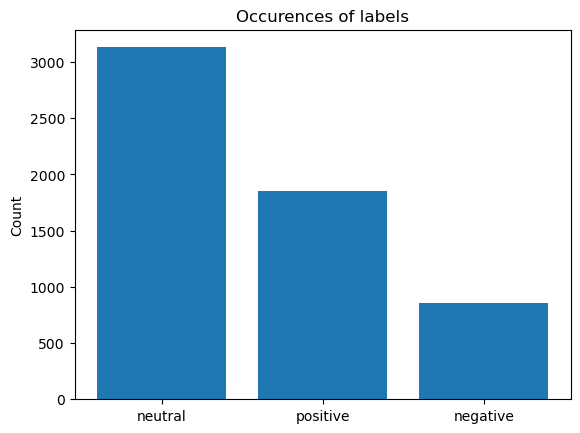

In [5]:
fig,ax = plt.subplots()
ax.bar(df["Sentiment"].value_counts().index,df["Sentiment"].value_counts().values)
ax.set_ylabel("Count")
ax.set_title("Occurences of labels")
print(df["Sentiment"].value_counts())

Dataset is **imbalanced**: almost 2x positive label than negative and 2x neutral label than positive.

**Solution**: use imblearn RandomOverSampler. (Under-sampling would make dataset insufficiently small)

## 2. Data Preparation

In [6]:
encoder = LabelEncoder()
encoder.fit(df["Sentiment"])

LabelEncoder()

In [7]:
X = df["Sentence"]
y = encoder.transform(df["Sentiment"])

In [8]:
print(y)

[2 0 2 ... 1 1 2]


In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [10]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4673,) (1169,) (4673,) (1169,)


In [11]:
sampler = RandomOverSampler(random_state=42)
X_over, y_over = sampler.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.reshape(-1, 1))

In [12]:
y_train = np.asarray(y_over).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [13]:
print(X_over.shape,y_over.shape)

(7629, 1) (7629,)


In [14]:
avg_words=round(sum([len(i.split()) for i in X_train])/len(X_train))

In [15]:
text_vectorizer = TextVectorization(max_tokens=10000,
                                    output_mode="int",
                                    output_sequence_length=avg_words)
text_vectorizer.adapt(X_train)

In [16]:
embedding = layers.Embedding(input_dim=10000, 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=avg_words, 
                             name="embedding_1")

## 3. Classification

### 3.1 Simple Keras CNN

In [17]:
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(3, activation='softmax')(x) 
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [18]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 21)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,280,387
Trainable params: 1,280,387
N

In [19]:
model_1_history = model_1.fit(X_over, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_over,
                              epochs=10)

Epoch 1/10
239/239 [==============================] - 3s 9ms/step - loss: 0.9905 - accuracy: 0.5813
Epoch 2/10
239/239 [==============================] - 2s 9ms/step - loss: 0.6560 - accuracy: 0.8064
Epoch 3/10
239/239 [==============================] - 2s 9ms/step - loss: 0.4276 - accuracy: 0.8807
Epoch 4/10
239/239 [==============================] - 2s 8ms/step - loss: 0.3135 - accuracy: 0.9093
Epoch 5/10
239/239 [==============================] - 2s 8ms/step - loss: 0.2509 - accuracy: 0.9262
Epoch 6/10
239/239 [==============================] - 2s 8ms/step - loss: 0.2122 - accuracy: 0.9350
Epoch 7/10
239/239 [==============================] - 2s 8ms/step - loss: 0.1880 - accuracy: 0.9404
Epoch 8/10
239/239 [==============================] - 2s 8ms/step - loss: 0.1716 - accuracy: 0.9463
Epoch 9/10
239/239 [==============================] - 2s 8ms/step - loss: 0.1583 - accuracy: 0.9476
Epoch 10/10
239/239 [==============================] - 2s 8ms/step - loss: 0.1498 - accuracy: 0.9503

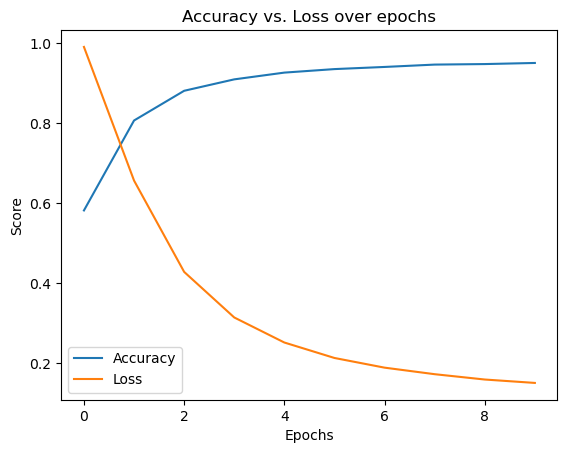

In [20]:
plt.plot(model_1_history.history["accuracy"],label="Accuracy")
plt.plot(model_1_history.history["loss"],label="Loss")
plt.title("Accuracy vs. Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

In [21]:
y_pred_cnn_vector = model_1.predict(X_test)

37/37 [==============================] - 0s 1ms/step


In [25]:
eval = model_1.evaluate(X_test,y_test)

37/37 [==============================] - 0s 2ms/step - loss: 1.0858 - accuracy: 0.6441


In [23]:
y_pred_cnn = []
for pred in y_pred_cnn_vector:
    if max(pred) ==pred[0]:
        y_pred_cnn.append(0)
    elif max(pred) ==pred[1]:
        y_pred_cnn.append(1)
    else:
        y_pred_cnn.append(2)